In [42]:
from pathlib import Path
from tqdm import tqdm
import os
import json
import copy
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [43]:
d = 20
Delta = np.pi / 30
p = 4
width = 100

def gen_data(n, d, Delta, p):
    x = torch.rand(n, d) * 2 - 1
    nc = int(n*p/(1+p))
    x[0:nc, 0] = np.sin(Delta)
    x[0:nc, 1] = -np.cos(Delta)
    x[0:nc, 2:] = 0
    x[nc:n, 0] = -np.sin(Delta)
    x[nc:n, 1] = -np.cos(Delta)
    x[nc:n, 2:] = 0
    y = torch.randn(n)
    for i in range(n):
        if x[i, 0] > 0:
            y[i] = 1.
        else:
            y[i] = -1.
    return x, y

In [44]:
def bino_(m, n):
    idi = int(n/2)
    x = np.random.randn(m, n)
    x[0, 0: idi] = 1/np.sqrt(width)
    x[0, idi:] = -1/np.sqrt(width)
    y = torch.from_numpy(x).float()
    return torch.nn.Parameter(y)

def uniball_(d, width, kappa):
    ka = kappa / np.sqrt(width)
    x = np.random.normal(0., 1/np.sqrt(d), (width, d))
    for i in range(width):
        ni = np.linalg.norm(x[i,:])
        x[i,:] = x[i,:] / ni
    z = x * ka
    y = torch.from_numpy(z).float()
    return torch.nn.Parameter(y)

def exp_loss(net, bx, by):
    by_pre = net(bx)
    loss_vec = torch.exp(- by_pre * by)
    loss = loss_vec.mean()
    return loss

class FNN(nn.Module):
    def __init__(self, d, width, kappa):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc1.weight = uniball_(d, width, kappa)
        self.fc2 = nn.Linear(width, 1, bias=False)
        self.fc2.weight = bino_(self.fc2.weight.shape[0], self.fc2.weight.shape[1])

    def forward(self, x):
        o = self.fc1(x)
        o = torch.relu(o)
        o = self.fc2(o)
        return o.squeeze()

In [45]:
def eval_accuracy(model, bx, by):
    model.eval()
    n = len(by)
    with torch.no_grad():
        z = model(bx) * by
        correct = sum(z>0).item()
    return correct * 100.0 / n


In [46]:
def train(kappa, n_tr, nepochs, lr):

    x_tr, y_tr = gen_data(n_tr, d, Delta, p)
    
    x_tr = x_tr.to(device)
    y_tr = y_tr.to(device)

    net_SGD = FNN(d, width, kappa)
    opt_SGD = optim.SGD(net_SGD.fc1.parameters(), lr=lr)
    
    net_SGD = net_SGD.to(device)

    train_loss_SGD = []
    train_acc_SGD = []
    neurons_SGD = {}
    
    for epoch in tqdm(range(nepochs)):
        opt_SGD.zero_grad()
        if epoch % 5 == 0:
            net_copy = copy.deepcopy(net_SGD)
            neurons_SGD[epoch] = net_copy.fc1.weight.detach().cpu().numpy()
            del net_copy
        train_loss = exp_loss(net_SGD, x_tr, y_tr)
        train_loss_SGD.append(train_loss.item())
        train_acc = eval_accuracy(net_SGD, x_tr, y_tr)
        train_acc_SGD.append(train_acc)
        train_loss.backward()
        opt_SGD.step()
        if epoch % int(5e4) == 0:
            print(train_acc)

    return train_loss_SGD, train_acc_SGD, neurons_SGD

# kappa > lr

In [47]:
Epoch = int(1.5e5)
train_loss, train_acc, neurons_SGD = train(kappa=1e-1, n_tr=p+1, nepochs=Epoch, lr=1e-2)

  0%|          | 703/150000 [00:00<00:41, 3617.80it/s]

80.0


 34%|███▎      | 50496/150000 [00:11<00:21, 4535.95it/s]

100.0


 67%|██████▋   | 100491/150000 [00:22<00:11, 4387.52it/s]

100.0


100%|██████████| 150000/150000 [00:33<00:00, 4477.53it/s]


Text(-29.93345690017685, 0.5, 'log(loss)')

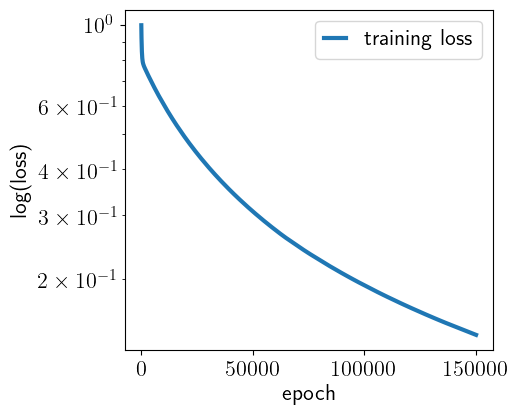

In [48]:
from matplotlib import rcParams
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath}",
    "font.family": "sans-serif",
#     "font.serif": ["Calibri"abs],
    "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.5,  # thin gridlines
    "axes.titlesize" : 16,
    "axes.labelsize" : 16,
    "lines.linewidth" : 3,
    "lines.markersize" : 8,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "figure.figsize" : (5, 4),
    "legend.fontsize" : 16,
    "legend.handlelength": 1,
#     "savefig.bbox": "tight",
#     "savefig.dpi": 300,
})
import matplotlib.pyplot as plt

x = range(len(train_loss))
plt.semilogy(x, train_loss, color='C0', label='training loss')
plt.legend()
plt.tight_layout()
plt.xlabel('epoch')
plt.ylabel('log(loss)')

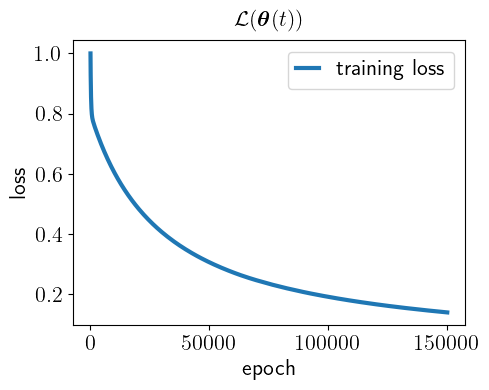

In [49]:
x = range(len(train_loss))
# plt.plot(x, train_loss, color='C0')
plt.plot(x, train_loss, color='C0', label='training loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(r'$\mathcal{L}(\boldsymbol{\theta}(t))$', pad=10)
plt.tight_layout()
plt.savefig("./figs/loss.pdf", dpi=500)

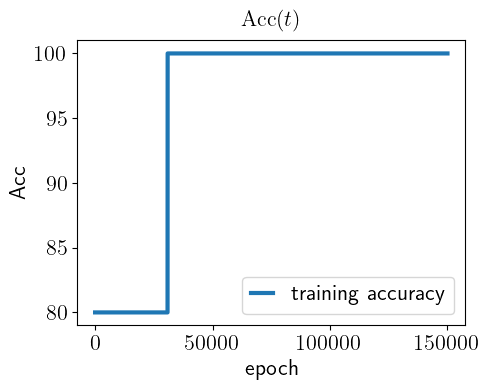

In [50]:
x = range(len(train_acc))
plt.plot(x, train_acc, color='C0', label="training accuracy")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.title(r'${\rm Acc}(t)$', pad=10)
plt.tight_layout()
plt.savefig("./figs/acc.pdf", dpi=500)

In [51]:
net_ana = {"loss": train_loss, "acc": train_acc, "neuron": neurons_SGD, "d": d, "Delta": Delta, 'width':width, "T": Epoch, "modify": 1}
import pickle
with open("./net_ana.p", "wb") as f:
    pickle.dump(net_ana, f)